In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline
 
from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.loss import RMSELoss
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Loading specific settings (some defined by the "run-notebooks.sh" script)

In [3]:
%run settings.py

dataset = chirps
step = 5
lr = 0.001
model_name = stconvs2s-c
version = 4
cuda = 0
dropout_rate = 0.0
only_training = False
epochs = 50
batch_size = 15
validation_split = 0.2
test_split = 0.2
dataset_file = ../data/dataset-chirps-1981-2019-seq5-ystep5.nc
model_param = {'num_layers': 2, 'kernel_size': 5, 'hidden_dim': 8}


In [4]:
util = Util(model_name, version=version, prefix=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]=cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Seed (reproducibility)

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Loading the dataset

In [7]:
ds = xr.open_mfdataset(dataset_file)
if small_dataset: #useful for quick experimentation
    ds = ds[dict(sample=slice(0,500))]

In [8]:
train_dataset = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split)
val_dataset   = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split, is_validation=True)
test_dataset  = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split, is_test=True)

In [9]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [11]:
model_bulder = models[model_name]
print(model_bulder)

model = model_bulder(train_dataset.X.shape, model_param['num_layers'], model_param['hidden_dim'], 
                     model_param['kernel_size'], device, dropout_rate)
model.to(device)
criterion = RMSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, eps=1e-6)

<class 'model.stconvs2s.STConvS2S_C'>


Training the model

In [12]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                  device, util, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename, is_chirps)

Train on 8376 samples, validate on 2792 samples
Epoch: 1/50 - loss: 6.4259 - val_loss: 6.4030
=> Saving a new best
Epoch: 2/50 - loss: 6.3788 - val_loss: 6.3877
=> Saving a new best
Epoch: 3/50 - loss: 6.3653 - val_loss: 6.6883
Epoch: 4/50 - loss: 6.3555 - val_loss: 6.3653
=> Saving a new best
Epoch: 5/50 - loss: 6.3490 - val_loss: 6.3656
Epoch: 6/50 - loss: 6.3444 - val_loss: 6.3603
=> Saving a new best
Epoch: 7/50 - loss: 6.3396 - val_loss: 6.3526
=> Saving a new best
Epoch: 8/50 - loss: 6.3356 - val_loss: 6.3555
Epoch: 9/50 - loss: 6.3328 - val_loss: 6.4222
Epoch: 10/50 - loss: 6.3311 - val_loss: 6.4780
Epoch: 11/50 - loss: 6.3295 - val_loss: 6.3400
=> Saving a new best
Epoch: 12/50 - loss: 6.3273 - val_loss: 6.3650
Epoch: 13/50 - loss: 6.3251 - val_loss: 6.3408
Epoch: 14/50 - loss: 6.3243 - val_loss: 6.3735
Epoch: 15/50 - loss: 6.3233 - val_loss: 6.3388
=> Saving a new best
Epoch: 16/50 - loss: 6.3218 - val_loss: 6.3336
=> Saving a new best
Epoch: 17/50 - loss: 6.3210 - val_loss: 6

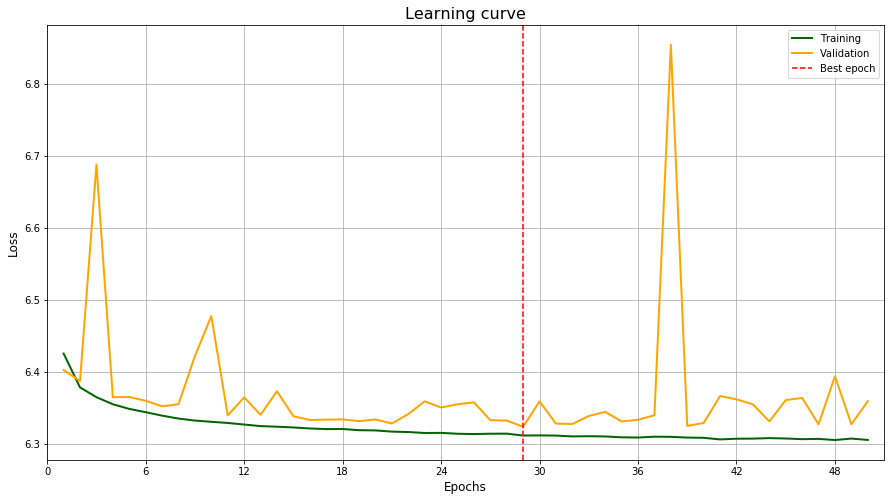

In [13]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Loss', 'Learning curve', inline=True)

Loading and Evaluating the model

=> Loaded checkpoint chirps_4_20200625-003933.pth.tar (best epoch: 29, validation rmse: 6.3243)
>>>>>>>>> Metric per observation (lat x lon) at each time step (t)
RMSE
6.314095113366683,6.298605174304329,6.297980305982784,6.31683965290294,6.328703752813492
MAE
2.8454002161077,2.7969545910065188,2.796236692902876,2.8621308969303887,2.862605518835751
>>>>>>>>
Test RMSE: 6.3131
Test MAE: 2.8327


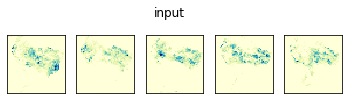

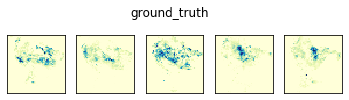

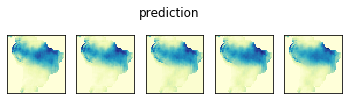

In [14]:
test_rmse, test_mae = None, None
evaluator = Evaluator(model, criterion, optimizer, test_loader, device, util, step)
best_epoch, val_loss = evaluator.load_checkpoint(checkpoint_filename)
if not(only_training):
    test_rmse, test_mae = evaluator.eval(is_chirps=is_chirps)
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

In [15]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [16]:
model_info = {'Notebook': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_rmse': test_rmse,
              'test_mae': test_mae,
              'step': step,
              'num_layers': model_param['num_layers'],
              'kernel_size': model_param['kernel_size'],
              'hidden_dim': model_param['hidden_dim'],
              'dropout_rate': dropout_rate,
              'learning_rate': lr,
              'dataset': dataset,
              'hostname': platform.node()}

In [17]:
util.send_email(model_info)

email sent
